# Skip-gram word2vec

In this notebook, I'll lead you through using TensorFlow to implement the word2vec algorithm using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [NIPS paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for word2vec also from Mikolov et al.
* An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara
* TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)

## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation. 

![one-hot encodings](assets/one_hot_encoding.png)

To solve this problem and greatly increase the efficiency of our networks, we use what are called embeddings. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

![lookup](assets/lookup_matrix.png)

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='assets/tokenize_lookup.png' width=500>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix as well.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.



## Word2Vec

The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.

<img src="assets/word2vec_architectures.png" width="500">

In this implementation, we'll be using the skip-gram architecture because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

First up, importing packages.

In [1]:
import time

import numpy as np
import tensorflow as tf

import utils

Load the [text8 dataset](http://mattmahoney.net/dc/textdata.html), a file of cleaned up Wikipedia articles from Matt Mahoney. The next cell will download the data set to the `data` folder. Then you can extract it and delete the archive file to save storage space.

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

## Preprocessing

Here I'm fixing up the text to make training easier. This comes from the `utils` module I wrote. The `preprocess` function coverts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. I'm also removing all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. If you want to write your own functions for this stuff, go for it.

In [3]:
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [4]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


And here I'm creating dictionaries to convert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list `int_words`.

In [5]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

#AE
print(vocab_to_int['the'])
print(int_words[0])
print(int_to_vocab[5233])
print(int_to_vocab[0])

0
5233
anarchism
the


## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

I'm going to leave this up to you as an exercise. This is more of a programming challenge, than about deep learning specifically. But, being able to prepare your data for your network is an important skill to have. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

In [6]:
print(vocab_to_int['of'])
print(int_words[:30])
#AE
print(vocab_to_int['the'])
print(int_to_vocab[0])

print(int_words[0])
print(int_to_vocab[5233])
print(int_to_vocab[11])

1
[5233, 3080, 11, 5, 194, 1, 3133, 45, 58, 155, 127, 741, 476, 10571, 133, 0, 27349, 1, 0, 102, 854, 2, 0, 15067, 58112, 1, 0, 150, 854, 3580]
0
the
5233
anarchism
as


In [7]:
# FAILED ATTEMPTS THAT TAUGHT ME A FEW THINGS ABOUT PANDAS

#indexes['freq'] = indexes['indexes'].value_counts(sort=False)

#indexes['indexes'].value_counts()
#indexes['prob'] = indexes['indexes'].value_counts(sort=False)
#indexes


#word_indexes = pd.concat(
#    [
#        word_indexes,
#        pd.DataFrame(
#            [
#                [word_indexes.groupby('indexes')['indexes'].transform('count'), 
#                 1 - np.sqrt(word_indexes.groupby('indexes')['indexes'].transform('count').min() / word_indexes.groupby('indexes')['indexes'].transform('count')), 
#                 np.random.choice([0, 1], p=[np.sqrt(word_indexes.groupby('indexes')['indexes'].transform('count').min() / word_indexes.groupby('indexes')['indexes'].transform('count')), 
#                                            1 - np.sqrt(word_indexes.groupby('indexes')['indexes'].transform('count').min() / word_indexes.groupby('indexes')['indexes'].transform('count'))
#                                            ]
#                                 )
#                ]
#            ], 
#            index=word_indexes.index, 
#            columns=['freq', 'prob', 'discard']
#        )
#    ], axis=1
#)

#word_indexes['discard'] = np.random.choice([0, 1], p=[1 - word_indexes['prob'], word_indexes['prob']])
#word_indexes[['prob', 'discard']] = pd.DataFrame([
#    [1 - np.sqrt(thresh / word_indexes['freq']), 
#     np.random.choice([0, 1], p=[np.sqrt(thresh / word_indexes['freq']), 1 - np.sqrt(thresh / word_indexes['freq'])])
#    ]
#], index=word_indexes.index)

#print(len(int_words))
#print(indexes[:3])
#print(indexes['indexes'].value_counts(sort=False))
#print(indexes.indexes.value_counts()[11])
#print(indexes.indexes.value_counts()[5233])
#print(indexes.indexes.value_counts()[0])
#indexes = pd.DataFrame({'indexes': int_words})

#word_indexes['discard'] = np.random.choice([0, 1], p=[1 - word_indexes['prob'], word_indexes['prob']])
#word_indexes
#word_indexes[word_indexes['freq'].map(lambda x: x < thresh + 1)]
#word_indexes['discard'] = word_indexes['prob']
#word_indexes[word_indexes['discard'].apply(
#    (lambda x: np.random.choice(
#        [True, False], 
#        [1 - word_indexes.prob, word_indexes.prob]
#    )), axis='columns'
#)]

In [8]:
import pandas as pd
import numpy as np

print("Creating Pandas dataframe...")
word_indexes = pd.DataFrame({'indexes': int_words})

## Your code here
#train_words = # The final subsampled word list

print("Calculating frequences...")
word_indexes['freq'] = word_indexes.groupby('indexes')['indexes'].transform('count')
#thresh = 100000
print("Calculating threshold...")
thresh = word_indexes['freq'].min()
print("Calculating probabilities...")
word_indexes['prob'] = 1 - np.sqrt(thresh / word_indexes['freq'])

nrow = 0
tcnt = 0
rec_cnt = 10000
def choice_of_word_discard(row):
    global nrow, tcnt, rec_cnt
    nrow += 1
    if ((nrow // rec_cnt) != tcnt):
        tcnt += 1
        print("Calculated discard of ",tcnt, " * ", rec_cnt, " records")
    return np.random.choice([True, False], p=[row['prob'], 1 - row['prob']])

print("Calculating discard...")
word_indexes['discard'] = word_indexes.apply(lambda row: choice_of_word_discard(row), axis=1)
print("Getting kept word indexes...")
kept_word_indexes = word_indexes[word_indexes['discard'] == False]
print("Converting kept word indexes to list...")
train_words = kept_word_indexes['indexes'].tolist()

Creating Pandas dataframe...
Calculating frequences...
Calculating threshold...
Calculating probabilities...
Calculating discard...
Calculated discard of  1  *  10000  records
Calculated discard of  2  *  10000  records
Calculated discard of  3  *  10000  records
Calculated discard of  4  *  10000  records
Calculated discard of  5  *  10000  records
Calculated discard of  6  *  10000  records
Calculated discard of  7  *  10000  records
Calculated discard of  8  *  10000  records
Calculated discard of  9  *  10000  records
Calculated discard of  10  *  10000  records
Calculated discard of  11  *  10000  records
Calculated discard of  12  *  10000  records
Calculated discard of  13  *  10000  records
Calculated discard of  14  *  10000  records
Calculated discard of  15  *  10000  records
Calculated discard of  16  *  10000  records
Calculated discard of  17  *  10000  records
Calculated discard of  18  *  10000  records
Calculated discard of  19  *  10000  records
Calculated discard of 

Calculated discard of  179  *  10000  records
Calculated discard of  180  *  10000  records
Calculated discard of  181  *  10000  records
Calculated discard of  182  *  10000  records
Calculated discard of  183  *  10000  records
Calculated discard of  184  *  10000  records
Calculated discard of  185  *  10000  records
Calculated discard of  186  *  10000  records
Calculated discard of  187  *  10000  records
Calculated discard of  188  *  10000  records
Calculated discard of  189  *  10000  records
Calculated discard of  190  *  10000  records
Calculated discard of  191  *  10000  records
Calculated discard of  192  *  10000  records
Calculated discard of  193  *  10000  records
Calculated discard of  194  *  10000  records
Calculated discard of  195  *  10000  records
Calculated discard of  196  *  10000  records
Calculated discard of  197  *  10000  records
Calculated discard of  198  *  10000  records
Calculated discard of  199  *  10000  records
Calculated discard of  200  *  100

Calculated discard of  358  *  10000  records
Calculated discard of  359  *  10000  records
Calculated discard of  360  *  10000  records
Calculated discard of  361  *  10000  records
Calculated discard of  362  *  10000  records
Calculated discard of  363  *  10000  records
Calculated discard of  364  *  10000  records
Calculated discard of  365  *  10000  records
Calculated discard of  366  *  10000  records
Calculated discard of  367  *  10000  records
Calculated discard of  368  *  10000  records
Calculated discard of  369  *  10000  records
Calculated discard of  370  *  10000  records
Calculated discard of  371  *  10000  records
Calculated discard of  372  *  10000  records
Calculated discard of  373  *  10000  records
Calculated discard of  374  *  10000  records
Calculated discard of  375  *  10000  records
Calculated discard of  376  *  10000  records
Calculated discard of  377  *  10000  records
Calculated discard of  378  *  10000  records
Calculated discard of  379  *  100

Calculated discard of  537  *  10000  records
Calculated discard of  538  *  10000  records
Calculated discard of  539  *  10000  records
Calculated discard of  540  *  10000  records
Calculated discard of  541  *  10000  records
Calculated discard of  542  *  10000  records
Calculated discard of  543  *  10000  records
Calculated discard of  544  *  10000  records
Calculated discard of  545  *  10000  records
Calculated discard of  546  *  10000  records
Calculated discard of  547  *  10000  records
Calculated discard of  548  *  10000  records
Calculated discard of  549  *  10000  records
Calculated discard of  550  *  10000  records
Calculated discard of  551  *  10000  records
Calculated discard of  552  *  10000  records
Calculated discard of  553  *  10000  records
Calculated discard of  554  *  10000  records
Calculated discard of  555  *  10000  records
Calculated discard of  556  *  10000  records
Calculated discard of  557  *  10000  records
Calculated discard of  558  *  100

Calculated discard of  716  *  10000  records
Calculated discard of  717  *  10000  records
Calculated discard of  718  *  10000  records
Calculated discard of  719  *  10000  records
Calculated discard of  720  *  10000  records
Calculated discard of  721  *  10000  records
Calculated discard of  722  *  10000  records
Calculated discard of  723  *  10000  records
Calculated discard of  724  *  10000  records
Calculated discard of  725  *  10000  records
Calculated discard of  726  *  10000  records
Calculated discard of  727  *  10000  records
Calculated discard of  728  *  10000  records
Calculated discard of  729  *  10000  records
Calculated discard of  730  *  10000  records
Calculated discard of  731  *  10000  records
Calculated discard of  732  *  10000  records
Calculated discard of  733  *  10000  records
Calculated discard of  734  *  10000  records
Calculated discard of  735  *  10000  records
Calculated discard of  736  *  10000  records
Calculated discard of  737  *  100

Calculated discard of  895  *  10000  records
Calculated discard of  896  *  10000  records
Calculated discard of  897  *  10000  records
Calculated discard of  898  *  10000  records
Calculated discard of  899  *  10000  records
Calculated discard of  900  *  10000  records
Calculated discard of  901  *  10000  records
Calculated discard of  902  *  10000  records
Calculated discard of  903  *  10000  records
Calculated discard of  904  *  10000  records
Calculated discard of  905  *  10000  records
Calculated discard of  906  *  10000  records
Calculated discard of  907  *  10000  records
Calculated discard of  908  *  10000  records
Calculated discard of  909  *  10000  records
Calculated discard of  910  *  10000  records
Calculated discard of  911  *  10000  records
Calculated discard of  912  *  10000  records
Calculated discard of  913  *  10000  records
Calculated discard of  914  *  10000  records
Calculated discard of  915  *  10000  records
Calculated discard of  916  *  100

Calculated discard of  1072  *  10000  records
Calculated discard of  1073  *  10000  records
Calculated discard of  1074  *  10000  records
Calculated discard of  1075  *  10000  records
Calculated discard of  1076  *  10000  records
Calculated discard of  1077  *  10000  records
Calculated discard of  1078  *  10000  records
Calculated discard of  1079  *  10000  records
Calculated discard of  1080  *  10000  records
Calculated discard of  1081  *  10000  records
Calculated discard of  1082  *  10000  records
Calculated discard of  1083  *  10000  records
Calculated discard of  1084  *  10000  records
Calculated discard of  1085  *  10000  records
Calculated discard of  1086  *  10000  records
Calculated discard of  1087  *  10000  records
Calculated discard of  1088  *  10000  records
Calculated discard of  1089  *  10000  records
Calculated discard of  1090  *  10000  records
Calculated discard of  1091  *  10000  records
Calculated discard of  1092  *  10000  records
Calculated di

Calculated discard of  1247  *  10000  records
Calculated discard of  1248  *  10000  records
Calculated discard of  1249  *  10000  records
Calculated discard of  1250  *  10000  records
Calculated discard of  1251  *  10000  records
Calculated discard of  1252  *  10000  records
Calculated discard of  1253  *  10000  records
Calculated discard of  1254  *  10000  records
Calculated discard of  1255  *  10000  records
Calculated discard of  1256  *  10000  records
Calculated discard of  1257  *  10000  records
Calculated discard of  1258  *  10000  records
Calculated discard of  1259  *  10000  records
Calculated discard of  1260  *  10000  records
Calculated discard of  1261  *  10000  records
Calculated discard of  1262  *  10000  records
Calculated discard of  1263  *  10000  records
Calculated discard of  1264  *  10000  records
Calculated discard of  1265  *  10000  records
Calculated discard of  1266  *  10000  records
Calculated discard of  1267  *  10000  records
Calculated di

Calculated discard of  1422  *  10000  records
Calculated discard of  1423  *  10000  records
Calculated discard of  1424  *  10000  records
Calculated discard of  1425  *  10000  records
Calculated discard of  1426  *  10000  records
Calculated discard of  1427  *  10000  records
Calculated discard of  1428  *  10000  records
Calculated discard of  1429  *  10000  records
Calculated discard of  1430  *  10000  records
Calculated discard of  1431  *  10000  records
Calculated discard of  1432  *  10000  records
Calculated discard of  1433  *  10000  records
Calculated discard of  1434  *  10000  records
Calculated discard of  1435  *  10000  records
Calculated discard of  1436  *  10000  records
Calculated discard of  1437  *  10000  records
Calculated discard of  1438  *  10000  records
Calculated discard of  1439  *  10000  records
Calculated discard of  1440  *  10000  records
Calculated discard of  1441  *  10000  records
Calculated discard of  1442  *  10000  records
Calculated di

Calculated discard of  1597  *  10000  records
Calculated discard of  1598  *  10000  records
Calculated discard of  1599  *  10000  records
Calculated discard of  1600  *  10000  records
Calculated discard of  1601  *  10000  records
Calculated discard of  1602  *  10000  records
Calculated discard of  1603  *  10000  records
Calculated discard of  1604  *  10000  records
Calculated discard of  1605  *  10000  records
Calculated discard of  1606  *  10000  records
Calculated discard of  1607  *  10000  records
Calculated discard of  1608  *  10000  records
Calculated discard of  1609  *  10000  records
Calculated discard of  1610  *  10000  records
Calculated discard of  1611  *  10000  records
Calculated discard of  1612  *  10000  records
Calculated discard of  1613  *  10000  records
Calculated discard of  1614  *  10000  records
Calculated discard of  1615  *  10000  records
Calculated discard of  1616  *  10000  records
Calculated discard of  1617  *  10000  records
Calculated di

In [7]:
# Alternative way (from the solution notebook) to reduce incidence of often used words. (much faster)
from collections import Counter
import random

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you choose a random number of words from the window.

In [8]:
print(len(train_words))
import random as r

def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    # Your code here
    subwindow_sz = r.randint(1, window_size + 1)
    
    left_boundary = idx - subwindow_sz
    if (left_boundary < 0): left_boundary = 0
    right_boundary = idx + subwindow_sz + 1
    
    words2return = set(words[left_boundary:idx] + words[idx + 1:right_boundary]) # converting to set to sift out duplicate words
    
    return list(words2return) # converting back to list and returning

4628916


Here's a function that returns batches for our network. The idea is that it grabs `batch_size` words from a words list. Then for each of those words, it gets the target words in the window. I haven't found a way to pass in a random number of target words and get it to work with the architecture, so I make one row per input-target pair. This is a generator function by the way, helps save memory.

In [9]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

## Building the graph

From [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), we can see the general structure of our network.
![embedding_network](./assets/skip_gram_net_arch.png)

The input words are passed in as integers. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.

I'm going to have you build the graph in stages now. First off, creating the `inputs` and `labels` placeholders like normal.

> **Exercise:** Assign `inputs` and `labels` using `tf.placeholder`. We're going to be passing in integers, so set the data types to `tf.int32`. The batches we're passing in will have varying sizes, so set the batch sizes to [`None`]. To make things work later, you'll need to set the second dimension of `labels` to `None` or `1`.

In [10]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, shape=None)
    labels = tf.placeholder(tf.int32, shape=(None, 1))

## Embedding



The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.


> **Exercise:** Tensorflow provides a convenient function [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) that does this lookup for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use `tf.nn.embedding_lookup` to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform).

In [11]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    #embedding = np.ndarray(shape=(n_vocab, n_embedding), dtype=float)
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))# create embedding weight matrix here
    embed = tf.nn.embedding_lookup(embedding, inputs) # use tf.nn.embedding_lookup to get the hidden layer output

## Negative sampling



For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

> **Exercise:** Below, create weights and biases for the softmax layer. Then, use [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss) to calculate the loss. Be sure to read the documentation to figure out how it works.

In [12]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    # AE: softmax_w = tf.nn.softmax(embedding) # create softmax weight matrix here
    # AE: So creating a new weights matrix here instead of using the embedding, because embedding is the matrix between input vector
    # AE: and hidden layer, but here we need between hidden layer and outputs. Just that outputs and inputs happen to be a vector
    # AE: of the same dimensionality
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1)) # create softmax weight matrix here
    #softmax_b = tf.Variable(tf.random_uniform([n_vocab], -1, 1))# create softmax biases here
    softmax_b = tf.Variable(tf.zeros(n_vocab))# create softmax biases here
    
    # Calculate the loss using negative sampling
    # AE: loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, labels, inputs, n_sampled, n_vocab)
    # AE: So embed instead of inputs, because our inputs to this softmax layer will be the actual hidden layer from the graph
    # AE: (or rather the portion from the hidden layer that corresponds to our inputs)
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, labels, embed, n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation

This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [13]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    # AE: I guess we normalise the weights here so that they are all between 0 and 1 for example.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    
    # AE: What a wonderful way to calculate similarity of two matrices!!!! :)
    # AE: Or in this case how much of normalisation was neccessary
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [14]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


## Training

Below is the code to train the network. Every 100 batches it reports the training loss. Every 1000 batches, it'll print out the validation words.

In [15]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    # AE: finding weights in the matrix that needed least normalisation and we'll then
                    # AE: find the corresponding words to that matrix
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/10 Iteration: 100 Avg. Training loss: 5.6623 0.9671 sec/batch
Epoch 1/10 Iteration: 200 Avg. Training loss: 5.6517 0.9670 sec/batch
Epoch 1/10 Iteration: 300 Avg. Training loss: 5.5084 0.9686 sec/batch
Epoch 1/10 Iteration: 400 Avg. Training loss: 5.5925 0.9658 sec/batch
Epoch 1/10 Iteration: 500 Avg. Training loss: 5.5076 0.9661 sec/batch
Epoch 1/10 Iteration: 600 Avg. Training loss: 5.5369 0.9650 sec/batch
Epoch 1/10 Iteration: 700 Avg. Training loss: 5.5649 0.9671 sec/batch
Epoch 1/10 Iteration: 800 Avg. Training loss: 5.5534 0.9769 sec/batch
Epoch 1/10 Iteration: 900 Avg. Training loss: 5.4842 0.9939 sec/batch
Epoch 1/10 Iteration: 1000 Avg. Training loss: 5.4076 1.0061 sec/batch
Nearest to been: ordinis, azusa, inimitable, lev, olympus, brady, spoken, vogler,
Nearest to all: mcvie, outline, leonardo, committed, theories, transoceanic, stoves, phoebastria,
Nearest to into: waza, enslaved, floor, pradesh, abruptly, basinger, utraquists, associated,
Nearest to when: dili, pat

Epoch 1/10 Iteration: 4100 Avg. Training loss: 4.6705 1.0913 sec/batch
Epoch 1/10 Iteration: 4200 Avg. Training loss: 4.6796 1.0878 sec/batch
Epoch 1/10 Iteration: 4300 Avg. Training loss: 4.6103 1.0933 sec/batch
Epoch 1/10 Iteration: 4400 Avg. Training loss: 4.6207 1.0908 sec/batch
Epoch 1/10 Iteration: 4500 Avg. Training loss: 4.6276 1.0875 sec/batch
Epoch 1/10 Iteration: 4600 Avg. Training loss: 4.6390 1.0861 sec/batch
Epoch 2/10 Iteration: 4700 Avg. Training loss: 4.6054 0.7820 sec/batch
Epoch 2/10 Iteration: 4800 Avg. Training loss: 4.5438 1.0899 sec/batch
Epoch 2/10 Iteration: 4900 Avg. Training loss: 4.5325 1.0839 sec/batch
Epoch 2/10 Iteration: 5000 Avg. Training loss: 4.5272 1.0820 sec/batch
Nearest to been: deteriorate, olympus, linguists, spoken, lev, vogler, daleks, combining,
Nearest to all: mcvie, committed, transoceanic, outline, leonardo, schumpeter, theories, stoves,
Nearest to into: abruptly, waza, floor, enslaved, enlightenment, associated, chemical, lapis,
Nearest t

Epoch 2/10 Iteration: 8100 Avg. Training loss: 4.3508 1.1074 sec/batch
Epoch 2/10 Iteration: 8200 Avg. Training loss: 4.2996 1.0978 sec/batch
Epoch 2/10 Iteration: 8300 Avg. Training loss: 4.3746 1.0924 sec/batch
Epoch 2/10 Iteration: 8400 Avg. Training loss: 4.3936 1.0889 sec/batch
Epoch 2/10 Iteration: 8500 Avg. Training loss: 4.3932 1.0865 sec/batch
Epoch 2/10 Iteration: 8600 Avg. Training loss: 4.2898 1.0906 sec/batch
Epoch 2/10 Iteration: 8700 Avg. Training loss: 4.3263 1.0826 sec/batch
Epoch 2/10 Iteration: 8800 Avg. Training loss: 4.3275 1.0859 sec/batch
Epoch 2/10 Iteration: 8900 Avg. Training loss: 4.2230 1.0920 sec/batch
Epoch 2/10 Iteration: 9000 Avg. Training loss: 4.3152 1.0916 sec/batch
Nearest to been: deteriorate, lads, tangle, ordinis, daleks, stibitz, ire, alleviation,
Nearest to all: mcvie, satisfy, transoceanic, causally, dynamically, committed, leonardo, motorsport,
Nearest to into: prescribes, abruptly, waza, artificially, excavators, xk, instantaneously, tertiary

Epoch 3/10 Iteration: 12100 Avg. Training loss: 4.2185 1.0934 sec/batch
Epoch 3/10 Iteration: 12200 Avg. Training loss: 4.1615 1.0891 sec/batch
Epoch 3/10 Iteration: 12300 Avg. Training loss: 4.1852 1.0839 sec/batch
Epoch 3/10 Iteration: 12400 Avg. Training loss: 4.2069 1.0878 sec/batch
Epoch 3/10 Iteration: 12500 Avg. Training loss: 4.1508 1.0929 sec/batch
Epoch 3/10 Iteration: 12600 Avg. Training loss: 4.1623 1.0891 sec/batch
Epoch 3/10 Iteration: 12700 Avg. Training loss: 4.1814 1.0936 sec/batch
Epoch 3/10 Iteration: 12800 Avg. Training loss: 4.1547 1.0956 sec/batch
Epoch 3/10 Iteration: 12900 Avg. Training loss: 4.2141 1.0933 sec/batch
Epoch 3/10 Iteration: 13000 Avg. Training loss: 4.2103 1.0911 sec/batch
Nearest to been: deteriorate, lads, tangle, vogler, nationalistic, reacted, ire, younger,
Nearest to all: mcvie, transoceanic, satisfy, committed, causally, leonardo, spokesperson, motorsport,
Nearest to into: prescribes, abruptly, garai, artificially, playhouse, brahmic, excavat

Epoch 4/10 Iteration: 16100 Avg. Training loss: 4.0575 1.1023 sec/batch
Epoch 4/10 Iteration: 16200 Avg. Training loss: 4.0955 1.0920 sec/batch
Epoch 4/10 Iteration: 16300 Avg. Training loss: 4.0779 1.0882 sec/batch
Epoch 4/10 Iteration: 16400 Avg. Training loss: 4.0698 1.0820 sec/batch
Epoch 4/10 Iteration: 16500 Avg. Training loss: 4.0791 1.0890 sec/batch
Epoch 4/10 Iteration: 16600 Avg. Training loss: 4.0583 1.0892 sec/batch
Epoch 4/10 Iteration: 16700 Avg. Training loss: 4.1002 1.0819 sec/batch
Epoch 4/10 Iteration: 16800 Avg. Training loss: 4.0910 1.0872 sec/batch
Epoch 4/10 Iteration: 16900 Avg. Training loss: 4.0994 1.0859 sec/batch
Epoch 4/10 Iteration: 17000 Avg. Training loss: 4.0636 1.0903 sec/batch
Nearest to been: deteriorate, lads, reacted, nationalistic, vogler, ire, tangle, exacerbated,
Nearest to all: causally, mcvie, satisfy, transoceanic, committed, motorsport, steepest, is,
Nearest to into: prescribes, artificially, garai, known, heathen, xk, excavators, playhouse,


Epoch 5/10 Iteration: 20100 Avg. Training loss: 4.0011 1.1009 sec/batch
Epoch 5/10 Iteration: 20200 Avg. Training loss: 4.0312 1.0910 sec/batch
Epoch 5/10 Iteration: 20300 Avg. Training loss: 3.9833 1.0904 sec/batch
Epoch 5/10 Iteration: 20400 Avg. Training loss: 4.0630 1.0849 sec/batch
Epoch 5/10 Iteration: 20500 Avg. Training loss: 4.0454 1.0872 sec/batch
Epoch 5/10 Iteration: 20600 Avg. Training loss: 3.9654 1.0888 sec/batch
Epoch 5/10 Iteration: 20700 Avg. Training loss: 4.0228 1.0874 sec/batch
Epoch 5/10 Iteration: 20800 Avg. Training loss: 4.0001 1.0881 sec/batch
Epoch 5/10 Iteration: 20900 Avg. Training loss: 4.0200 1.0876 sec/batch
Epoch 5/10 Iteration: 21000 Avg. Training loss: 4.0167 1.0831 sec/batch
Nearest to been: deteriorate, lads, vogler, ire, contracting, accounts, tangle, exacerbated,
Nearest to all: otherwise, causally, mcvie, satisfy, motorsport, transoceanic, is, other,
Nearest to into: garai, prescribes, artificially, xk, known, toc, heathen, fateful,
Nearest to wh

Epoch 6/10 Iteration: 24100 Avg. Training loss: 3.9754 1.0972 sec/batch
Epoch 6/10 Iteration: 24200 Avg. Training loss: 3.9903 1.0947 sec/batch
Epoch 6/10 Iteration: 24300 Avg. Training loss: 3.8625 1.0938 sec/batch
Epoch 6/10 Iteration: 24400 Avg. Training loss: 3.9434 1.0960 sec/batch
Epoch 6/10 Iteration: 24500 Avg. Training loss: 3.9164 1.0950 sec/batch
Epoch 6/10 Iteration: 24600 Avg. Training loss: 3.9091 1.0892 sec/batch
Epoch 6/10 Iteration: 24700 Avg. Training loss: 3.9504 1.0930 sec/batch
Epoch 6/10 Iteration: 24800 Avg. Training loss: 3.9452 1.0917 sec/batch
Epoch 6/10 Iteration: 24900 Avg. Training loss: 3.9291 1.0944 sec/batch
Epoch 6/10 Iteration: 25000 Avg. Training loss: 3.9511 1.0865 sec/batch
Nearest to been: deteriorate, lads, accounts, currently, as, precise, venezuelan, contracting,
Nearest to all: otherwise, other, causally, is, summands, steepest, a, transoceanic,
Nearest to into: garai, prescribes, heathen, known, fateful, artificially, xk, toc,
Nearest to when:

Epoch 7/10 Iteration: 28100 Avg. Training loss: 3.9155 1.0982 sec/batch
Epoch 7/10 Iteration: 28200 Avg. Training loss: 3.9165 1.0832 sec/batch
Epoch 7/10 Iteration: 28300 Avg. Training loss: 3.8823 1.0847 sec/batch
Epoch 7/10 Iteration: 28400 Avg. Training loss: 3.9293 1.0895 sec/batch
Epoch 7/10 Iteration: 28500 Avg. Training loss: 3.8867 1.0857 sec/batch
Epoch 7/10 Iteration: 28600 Avg. Training loss: 3.9589 1.0876 sec/batch
Epoch 7/10 Iteration: 28700 Avg. Training loss: 3.9546 1.0892 sec/batch
Epoch 7/10 Iteration: 28800 Avg. Training loss: 3.9615 1.0901 sec/batch
Epoch 7/10 Iteration: 28900 Avg. Training loss: 3.8447 1.0943 sec/batch
Epoch 7/10 Iteration: 29000 Avg. Training loss: 3.9025 1.0963 sec/batch
Nearest to been: currently, deteriorate, as, precise, lads, but, accounts, hksar,
Nearest to all: other, causally, otherwise, steepest, a, motorsport, transoceanic, afar,
Nearest to into: prescribes, known, both, artificially, heathen, garai, xk, fateful,
Nearest to when: dili, g

Epoch 7/10 Iteration: 32100 Avg. Training loss: 3.9313 1.1029 sec/batch
Epoch 7/10 Iteration: 32200 Avg. Training loss: 3.9175 1.0874 sec/batch
Epoch 7/10 Iteration: 32300 Avg. Training loss: 3.9404 1.0857 sec/batch
Epoch 8/10 Iteration: 32400 Avg. Training loss: 3.9215 0.0440 sec/batch
Epoch 8/10 Iteration: 32500 Avg. Training loss: 3.9406 1.0864 sec/batch
Epoch 8/10 Iteration: 32600 Avg. Training loss: 3.9237 1.0862 sec/batch
Epoch 8/10 Iteration: 32700 Avg. Training loss: 3.8671 1.0838 sec/batch
Epoch 8/10 Iteration: 32800 Avg. Training loss: 3.9196 1.0807 sec/batch
Epoch 8/10 Iteration: 32900 Avg. Training loss: 3.9036 1.0827 sec/batch
Epoch 8/10 Iteration: 33000 Avg. Training loss: 3.8687 1.0845 sec/batch
Nearest to been: as, currently, but, was, precise, hksar, that, deteriorate,
Nearest to all: other, a, causally, the, otherwise, motorsport, steepest, transoceanic,
Nearest to into: garai, prescribes, both, known, artificially, isa, xk, heathen,
Nearest to when: a, parthia, glaci

Epoch 8/10 Iteration: 36100 Avg. Training loss: 3.9716 1.0998 sec/batch
Epoch 8/10 Iteration: 36200 Avg. Training loss: 3.9530 1.0870 sec/batch
Epoch 8/10 Iteration: 36300 Avg. Training loss: 3.9419 1.0874 sec/batch
Epoch 8/10 Iteration: 36400 Avg. Training loss: 3.8746 1.0845 sec/batch
Epoch 8/10 Iteration: 36500 Avg. Training loss: 3.8854 1.3116 sec/batch
Epoch 8/10 Iteration: 36600 Avg. Training loss: 3.8554 1.0881 sec/batch
Epoch 8/10 Iteration: 36700 Avg. Training loss: 3.8504 1.0942 sec/batch
Epoch 8/10 Iteration: 36800 Avg. Training loss: 3.8876 1.0924 sec/batch
Epoch 8/10 Iteration: 36900 Avg. Training loss: 3.8816 1.0879 sec/batch
Epoch 8/10 Iteration: 37000 Avg. Training loss: 3.9190 1.0849 sec/batch
Nearest to been: was, currently, including, but, had, as, were, precise,
Nearest to all: other, a, causally, motorsport, liouville, otherwise, with, teach,
Nearest to into: both, garai, known, prescribes, artificially, isa, aimed, xk,
Nearest to when: a, parthia, glaciations, dil

Epoch 9/10 Iteration: 40100 Avg. Training loss: 3.8472 1.0966 sec/batch
Epoch 9/10 Iteration: 40200 Avg. Training loss: 3.8795 1.0882 sec/batch
Epoch 9/10 Iteration: 40300 Avg. Training loss: 3.8547 1.0945 sec/batch
Epoch 9/10 Iteration: 40400 Avg. Training loss: 3.8462 1.0905 sec/batch
Epoch 9/10 Iteration: 40500 Avg. Training loss: 3.9181 1.0972 sec/batch
Epoch 9/10 Iteration: 40600 Avg. Training loss: 3.8371 1.0967 sec/batch
Epoch 9/10 Iteration: 40700 Avg. Training loss: 3.9673 1.0912 sec/batch
Epoch 9/10 Iteration: 40800 Avg. Training loss: 3.9356 1.0874 sec/batch
Epoch 9/10 Iteration: 40900 Avg. Training loss: 3.9398 1.1854 sec/batch
Epoch 9/10 Iteration: 41000 Avg. Training loss: 3.8308 1.1915 sec/batch
Nearest to been: was, were, but, currently, including, as, had, that,
Nearest to all: other, causally, a, otherwise, with, liouville, teach, motorsport,
Nearest to into: known, the, both, garai, prescribes, aimed, xk, tipperary,
Nearest to when: parthia, a, never, though, dili, s

Epoch 10/10 Iteration: 44300 Avg. Training loss: 3.8380 1.0878 sec/batch
Epoch 10/10 Iteration: 44400 Avg. Training loss: 3.8801 1.0848 sec/batch
Epoch 10/10 Iteration: 44500 Avg. Training loss: 3.8805 1.0825 sec/batch
Epoch 10/10 Iteration: 44600 Avg. Training loss: 3.8410 1.0897 sec/batch
Epoch 10/10 Iteration: 44700 Avg. Training loss: 3.8670 1.0828 sec/batch
Epoch 10/10 Iteration: 44800 Avg. Training loss: 3.8804 1.0895 sec/batch
Epoch 10/10 Iteration: 44900 Avg. Training loss: 3.8427 1.0962 sec/batch
Epoch 10/10 Iteration: 45000 Avg. Training loss: 3.8408 1.0925 sec/batch
Nearest to been: was, were, that, including, currently, as, had, but,
Nearest to all: other, a, or, causally, with, there, of, the,
Nearest to into: both, known, the, aimed, garai, from, artificially, prescribes,
Nearest to when: a, parthia, this, though, an, never, the, glaciations,
Nearest to may: or, persons, this, are, starts, from, the, should,
Nearest to not: that, but, for, however, did, is, only, does,
Ne

Restore the trained network if you need to:

In [16]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [18]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

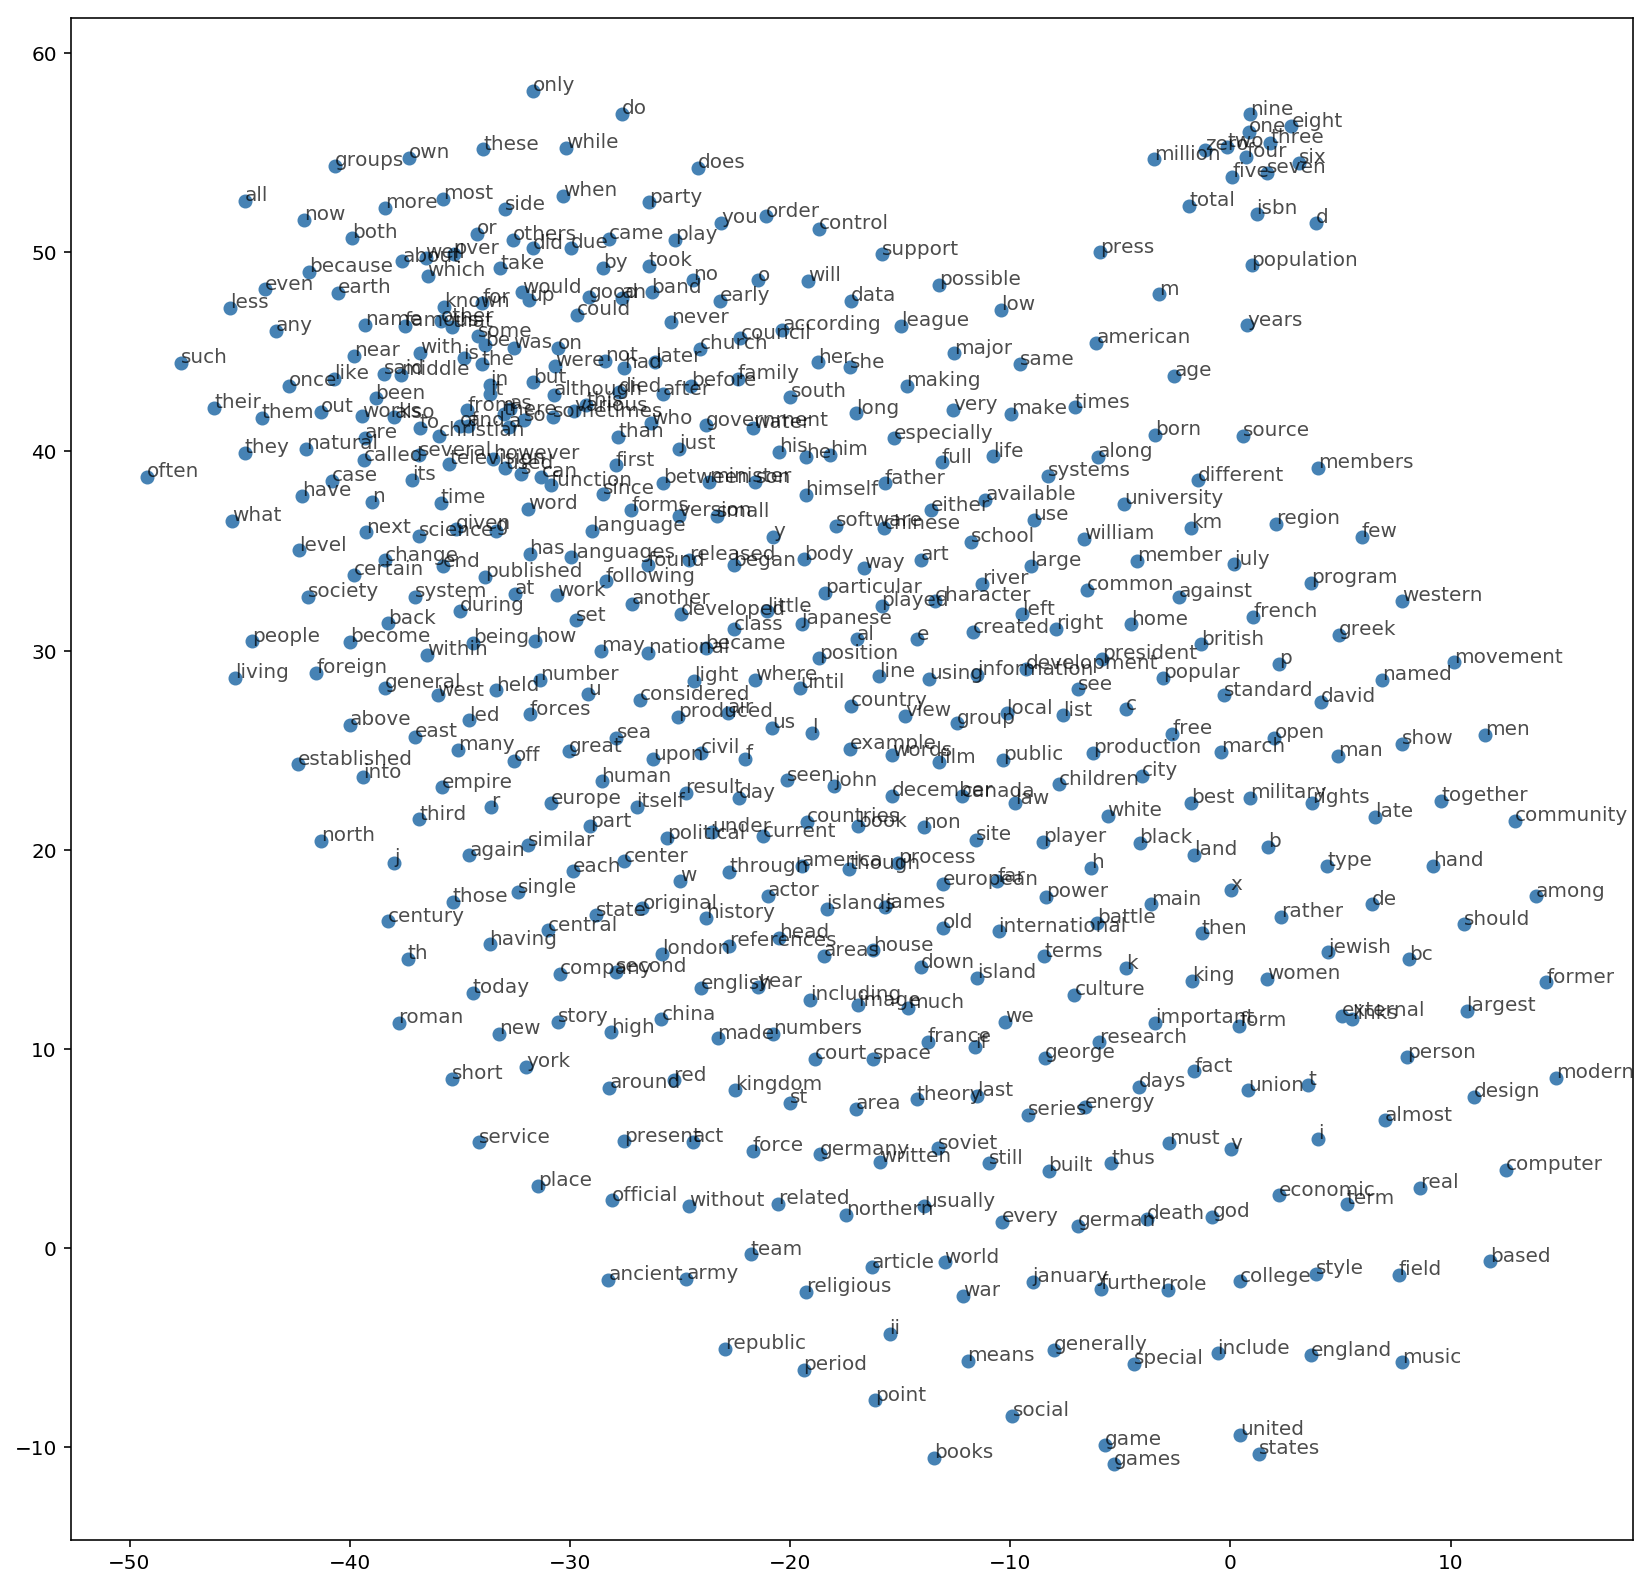

In [19]:
# AE: Calculates X and Y coordinates in a 2D plane from the 200 deep weight vector that we have for each word.
# AE: We do that for the first 500 words only though.
# AE: And then finally we plot each of those 500 words according to the calculated cooordinates.
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)